In [1]:
from bs4 import BeautifulSoup
from urllib2 import urlopen
import bs4
import pandas as pd
import pickle
import time
import calendar
import requests
import re
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split
import numpy as np

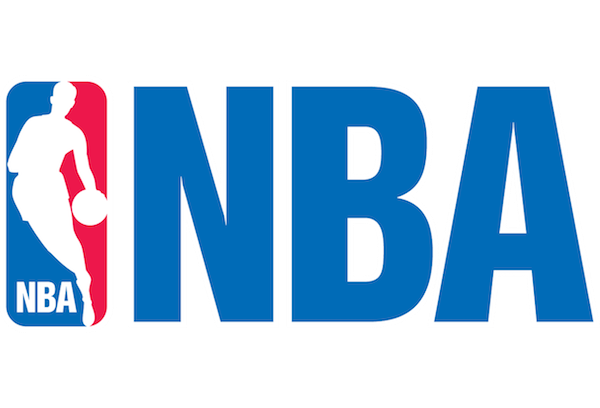

In [2]:
Image(filename='logo.png')

The NBA as a league has embraced analytics. Teams now make decisions based on data, which players fit in best to their system, how defense and offense should be played, which shots are valuable.

Because of this, lots of data is available online to be used an analyzed. I will be utilizing two different websites that specialize in NBA data; Basketball Reference and FiveThirtyEight. Basketball Reference gives data to fans, accessable in tables you can find yearly, weekly and daily stats for each team. I will focus on the 2016-2017 season, extracting each team along with their total wins, losses, win percentage, games behind the leader of their conference, points scored per game, and opponents points scored per game. This will be stored into a data frame and dumped as a pickle file

In [3]:
def startup():
    dailyStandings = "http://www.basketball-reference.com/leagues/NBA_2017_standings.html"
    allGames = "http://www.basketball-reference.com/leagues/NBA_2017_games-february.html"
    soup = BeautifulSoup(urlopen(dailyStandings), "lxml")
    allTeams = soup.find(class_="standings_confs table_wrapper").div.tbody

    # Lists of all of the types of data to be scraped
    totalTeams = []
    wins = []
    losses = []
    wl_perc = []
    gb = []
    ppg = []
    oppg = []
    conference = []
    
    # Use beautiful soup to find each of these data points 
    def fillLists(tagIn, conf):
        for i in tagIn:

            if isinstance(i, bs4.element.NavigableString):
                pass
            else:
                totalTeams.append(str((i.contents[0].find('a').text)))
                wins.append(int(i.contents[1].text))
                losses.append(int(i.contents[2].text))
                wl_perc.append(float(i.contents[3].text))
                try:
                    gb.append(float(i.contents[4].text))
                except:
                    gb.append(0.)

                ppg.append(float(i.contents[5].text))
                oppg.append(float(i.contents[6].text))
                conference.append(str(conf))
    
    # Find the tables that include the data for both conferences
    east = soup.find(class_="standings_confs table_wrapper").find("div",  {"id": "all_confs_standings_E"}).tbody
    west = soup.find(class_="standings_confs table_wrapper").find("div",  {"id": "all_confs_standings_W"}).tbody
    
    # Perform the scraping
    fillLists(west, 'West')
    fillLists(east, 'East')

    # Build the data frames that will be storing the data
    data = {'Team':totalTeams, 'Win':wins, 'Loss':losses, 'WL %':wl_perc, 'Conference':conference, 'Games Behind':gb, 'Points Per/G':ppg, 'Op Points Per/G':oppg}
    df = pd.DataFrame.from_dict(data)
    df = df[['Team', 'Conference', 'Win', 'Loss', 'WL %', 'Games Behind', 'Points Per/G', 'Op Points Per/G']]
    df = df.sort(['Win'], ascending=[False])
    
    # Write out the found data to a pickle file
    with open('nba.pickle', 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [4]:
startup()

/Users/adammorrow1/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Because games are played daily, I am setting up the post function so that in future implementation (the Dr. Jarvis final project), I will be able to test on my previously collected data so that I can predict who will win the matchup of each days games. So far, this function only grabs the url of the day it is run on's games. This will be further implemented in the future.

In [5]:
def post():
    with open('nba.pickle', 'rb') as handle:
        df = pickle.load(handle)

        date = time.strftime("%D:%M:%Y")
    month = date[:2]
    day = date[3:5]
    day = str(int(day))
    month = str(int(month))
    year = date[6:8]
    
    #print day, month, year
    cal = dict((str(k),v.lower()) for k,v in enumerate(calendar.month_name))
    #print cal[month]

    searchFor = ("/boxscores/index.cgi?month=%s&amp;day=%s&amp;year=%s" % (day, month, year))
    print searchFor
    #print df

In [6]:
post()

/boxscores/index.cgi?month=28&amp;day=2&amp;year=17


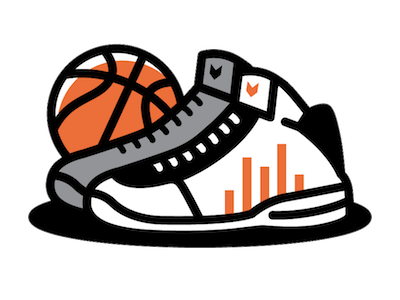

In [7]:
Image(filename='whiteshoe.png')
## Image used from fivethirtyeight.com

FiveThirtyEight, sometimes referred to as 538, is a website that focuses on opinion poll analysis, politics, economics, and sports blogging. The website, which takes its name from the number of electors in the United States electoral college, 538.

538 has implemented it's own numeric and statistical analysis on the NBA, projecting and ranking the success of the current teams. One of these methods is the CARM-ELO ranking. A play on words on the NBA players name CarMelo Anthony. Based off of the information on their website, the CARM-ELO ranking identifies similar players throughout NBA history and uses them to develop a probabilistic forecast of what a current NBA player’s future might look like. Thus the teams scores are decided by how each player stacks up to current and past players. I will factor this in as one of the comparison metrics used in my data. Also I will scrape and use their projections for projected record, point differential, percentage that the team will make the playoffs, and the percentage that they will win the top seed entering the playoffs

In [16]:
def fiveThreeEight():
    # Load in the data from baskeball reference, this will be used to build a master data frame
    with open('nba.pickle', 'rb') as handle:
        old = pickle.load(handle)
    
    # Open the URL in beautiful soup
    url538 = "https://projects.fivethirtyeight.com/2017-nba-predictions/"
    r = requests.get(url538)

    soup = BeautifulSoup(r.content,"lxml")
    soup = soup.find("table", { "id" : "standings-table" }).next.nextSibling.findAll("tr")
    
    # The data to be scraped
    names = []
    elo = []
    record = []
    pointDiff = []
    percMakePlayoffs = []
    percTopSeed = []
    df = pd.DataFrame()

    # Perform the scraping
    for i in soup:
        # Team names
        names.append(filter(str.isalpha, str(i.find(class_="team").text)))
        # CARMELO ranking
        elo.append(i.find(class_="num elo carmelo").text)
        # Projected record
        record.append(i.find(class_="num div proj-rec break").text)
        # Point Differential
        pointDiff.append(float(i.find(class_="num desktop").text))
        # Percentage make playoffs, have to trim given as a string %
        regex = re.compile('[^0-9]')
        pmakeP = regex.sub('',i.find(class_="pct div break").text)
        
        try:
            pmakeP = .01 * float(pmakeP)
        except: 
            print pmakeP
            # If clinched berth
            pmakeP =1
        percMakePlayoffs.append((pmakeP))
        # Percentage to make tope seed of the playoffs, have to trim given as a string %
        try:
            ptopP = regex.sub('',i.find(class_="pct top-seed").text)
            ptopP = .01 * float(ptopP)
        except:
            ptopP = .01
        percTopSeed.append(float(ptopP))
    
    # Build the data frame
    df['Name'] = names
    df['CARM-ELO'] = elo
    df['ProjRec 538'] = record
    df['PointDiff 538'] = pointDiff
    df['Make Playoffs % 538'] = percMakePlayoffs
    df['Top Seed % 538'] = percTopSeed


    # Create a list that will allow for a join on the two data frames
    mascots = list(old.Team)
    for i in xrange(len(mascots)):
        mascots[i] = mascots[i].rsplit(None, 1)[-1]
    old['Name'] = mascots

    # Fix the names for the 76ers and Trail Blazers, unique names that are messing up the naming system
    df = df.replace(to_replace='ers', value='76ers',)
    df = df.replace(to_replace='TrailBlazers', value='Trail Blazers',)
    old = old.replace(to_replace='Blazers', value='Trail Blazers',)
    
    # Merge the two data frames to build one master df
    df = df.merge(old, left_on='Name', right_on='Name', how='outer')
    # Reorder for simplicity
    df = df[['Name', 'Conference', 'Win', 'Loss', 'WL %',  'ProjRec 538', 'CARM-ELO', 'PointDiff 538', 'Games Behind', 'Make Playoffs % 538', 'Top Seed % 538', 'Points Per/G', 'Op Points Per/G']]
    # Write out the final master df
    with open('master.pickle', 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return df
    

In [19]:
df = fiveThreeEight()
df

,Name,Conference,Win,Loss,WL %,ProjRec 538,CARM-ELO,PointDiff 538,Games Behind,Make Playoffs % 538,Top Seed % 538,Points Per/G,Op Points Per/G
0,Warriors,West,50,9,0.847,68-14,1810,12.2,0.0,1.00,0.94,118.2,105.4
1,Spurs,West,45,13,0.776,62-20,1703,8.2,4.5,0.99,0.06,106.9,98.3
2,Cavaliers,East,41,17,0.707,55-27,1614,4.5,0.0,0.99,0.78,111.1,105.9
3,Jazz,West,37,22,0.627,51-31,1611,4.4,13.0,0.99,0.01,100.4,95.6
4,Rockets,West,42,19,0.689,55-27,1608,5.7,9.0,0.99,0.01,115.0,108.4
5,Clippers,West,36,23,0.610,50-32,1592,3.4,14.0,0.99,0.01,108.1,104.7
6,Grizzlies,West,35,25,0.583,48-34,1585,1.8,15.5,0.99,0.01,100.8,99.6
7,Celtics,East,38,22,0.633,52-30,1583,2.9,4.0,0.99,0.18,108.0,105.7
8,Wizards,East,34,23,0.596,47-35,1575,2.0,6.5,0.99,0.01,107.9,105.5
9,Raptors,East,36,24,0.600,49-33,1565,3.8,6.0,0.99,0.03,108.2,104.0


In [22]:
nums = df[['Win', 'Loss', 'WL %', 'CARM-ELO', 'PointDiff 538', 'Games Behind', 'Make Playoffs % 538', 'Top Seed % 538', 'Points Per/G', 'Op Points Per/G']]
bc = np.zeros((30,))
bc[:16] = 1
Xtrain,Xtest,Ytrain,Ytest = train_test_split(nums,bc,test_size=.3)    

Now that we have our data we can start making some predictions. We would like to know, who is going to make the playoffs? Lets take two teams as our samples, the Atlanta Hawks and the Golden State Warriors. The Warriors have already clinched a playoff birth, so our model should show that they do infact make it. The Hawks however are not as good this year and are more of a middle of the pack team, you will see below that my model predicts they will not make the playoffs. 

In [35]:
accuracy = []
# Train Data
for i in xrange(100):
    rfc = RFC(bootstrap=True).fit(Xtrain,Ytrain)
    accuracy.append(np.mean(np.abs(rfc.predict(Xtest) - Ytest)))

# Find the error
print np.mean(accuracy)
Hawks = np.array([72,9,0.559,1474,-0.7,8.5,0.96,0.01,103.4,104.2])
Warriors = np.array([50,9,0.847,1810,12.2,0.0,1.00,0.94,118.2,105.4])
# Predict if the Hawks will make the playoffs
print rfc.predict(Hawks.reshape(1, -1))
# Predict if the Warriors will make the playoffs
print rfc.predict(Warriors.reshape(1, -1))

# Show that multiple teams in the test data will make the playoffs
print rfc.predict(Xtest)

0.173333333333
[ 0.]
[ 1.]
[ 0.  1.  0.  0.  1.  0.  0.  0.  0.]
